In [1]:
# pip
#!pip install tqdm
#!pip install dask
import findspark
findspark.init()

In [2]:
# conda
# !conda install tqdm
# !conda install dask

In [3]:
# configuration, worked on using python@3.10.9 
import os
import urllib
import json
from threading import Thread, Lock
from tqdm import tqdm
import pyspark
import pandas
from pyspark import SQLContext


In [5]:
conf = pyspark.SparkConf()

sc = pyspark.SparkContext(conf=conf)
spark = pyspark.sql.SparkSession(sc)
spark.conf.set("spark.sql.shuffle.partitions", "5")
spark

In [6]:
# data folder
data_dir = 'data'

# data urls
historic_arrest_loc = { 'url': 'https://data.cityofnewyork.us/resource/8h9b-rp9u.json?$limit=15000000', 'filename': 'arrest.json' }
historic_complaint_loc = { 'url': 'https://data.cityofnewyork.us/resource/qgea-i56i.csv?$limit=15000000', 'filename': 'complaint.csv' }
historic_court_summons_loc = { 'url': 'https://data.cityofnewyork.us/resource/sv2w-rv3k.json?$limit=15000000', 'filename': 'summons.json' }
traffic_speed_loc = { 'url': 'https://data.cityofnewyork.us/resource/i4gi-tjb9.json?$limit=15000000', 'filename': 'speed.json' }
turnstile_loc = { 'url': 'https://data.ny.gov/resource/bjcb-yee3.csv?$limit=15000000', 'filename': 'turnstile.csv' }
subway_loc = { 'url': 'http://web.mta.info/developers/data/nyct/subway/Stations.csv?$limit=10000', 'filename': 'subway.csv' }

In [7]:
# download flags
downloadflag = True
redownload = False

thread_lock = Lock()

# download utils
def download_dataset_thread(loc, folder):
    with thread_lock:
         if ((not os.path.exists(os.path.join(folder, loc['filename']))) or redownload) and downloadflag:
            if os.path.isfile(os.path.join(folder, loc['filename'])):
                os.remove(os.path.join(folder, loc['filename']))
            if not os.path.exists(folder):
                os.makedirs(folder) 
            with tqdm(unit="B", unit_scale=True, desc=loc['filename'], miniters=1) as progress_bar:
                urllib.request.urlretrieve(loc['url'], os.path.join(folder, loc['filename']), lambda block_num, block_size, total_size: progress_bar.update(block_size))
            progress_bar.display()
        
def download_dataset(loc, folder):
    thread = Thread(target=download_dataset_thread, args=(loc, folder))
    thread.start()
    thread.join()
        

In [8]:
# download datasets
for dataset in [historic_arrest_loc,
                historic_complaint_loc,
                historic_court_summons_loc,
                turnstile_loc,
                subway_loc]:
    download_dataset(dataset, data_dir)

In [9]:
# dataframes
#arrest_df = spark.read.json(os.path.join(data_dir, historic_arrest_loc['filename']), multiLine=True)
#complaint_rdd = spark.read.csv(os.path.join(data_dir, historic_complaint_loc['filename']),header=True, inferSchema=True)
#summons_rdd = spark.read.json(os.path.join(data_dir, historic_court_summons_loc['filename']), multiLine=True)
#turnstile_rdd = spark.read.csv(os.path.join(data_dir, turnstile_loc['filename']), multiLine=True, header=True,inferSchema=True)
subway_df = spark.read.csv(os.path.join(data_dir, subway_loc['filename']), header=True, inferSchema=True).repartition(5)

In [10]:
from pyspark.sql.types import *

In [11]:
file_location = "D:\\Bigdata_project\\big-data-project\\data\\complaint.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df)

DataFrame[cmplnt_num: string, cmplnt_fr_dt: timestamp, cmplnt_fr_tm: timestamp, cmplnt_to_dt: timestamp, cmplnt_to_tm: string, addr_pct_cd: int, rpt_dt: timestamp, ky_cd: int, ofns_desc: string, pd_cd: double, pd_desc: string, crm_atpt_cptd_cd: string, law_cat_cd: string, boro_nm: string, loc_of_occur_desc: string, prem_typ_desc: string, juris_desc: string, jurisdiction_code: double, parks_nm: string, hadevelopt: string, housing_psa: string, x_coord_cd: int, y_coord_cd: int, susp_age_group: string, susp_race: string, susp_sex: string, transit_district: double, latitude: double, longitude: double, lat_lon: string, patrol_boro: string, station_name: string, vic_age_group: string, vic_race: string, vic_sex: string]

In [12]:
#temp_table_name = "sample_csv"

#df.createOrReplaceTempView(temp_table_name)

In [13]:
# Drop unnecessary columns
df = df.drop("PARKS_NM", "VIC_AGE_GROUP", "VIC_RACE", "VIC_SEX", "STATION_NAME", "PATROL_BORO", "TRANSIT_DISTRICT", 
             "SUSP_SEX", "SUSP_RACE", "SUSP_AGE_GROUP", "X_COORD_CD", "Y_COORD_CD", "HOUSING_PSA", "HADEVELOPT", 
             "JURISDICTION_CODE", "JURIS_DESC", "JURIS_DESC", "RPT_DT", "JURIS_DESC", "PREM_TYP_DESC",
             "PD_CD", "PD_DESC", "LOC_OF_OCCUR_DESC", "CMPLNT_TO_TM", "CMPLNT_TO_DT")

In [14]:
# Rename columns
df = df.toDF('Complaint_ID', 'Start_Date','Start_Time', 'Neighborhood', 'Offence_Code', 'Offence_Type',
        'Status','Offence_Level','Borough','Latitude','Longitude','Lat_Lon')


In [27]:
# Conver start date and end date to timestamp
from pyspark.sql import Row, SparkSession
from pyspark.sql.functions import *

df = df.withColumn('Start_Date', to_timestamp('Start_Date', 'MM/dd/yyyy'))
#df = df.filter(df['Start_Date'] >= lit('2006-01-01 00:00:00')).filter(df['Start_Date'] <= lit('2020-01-01 00:00:00'))
df = df.dropna()
df.count()

6910316

In [16]:
from pyspark.sql.functions import to_date 
from pyspark.sql.functions import year, month 
# Cast the data type to Date
df = df.withColumn('Date', to_date('Start_Date'))
df = df.withColumn('Hour', hour(df['Start_Time']))
# Create a new column of year number
df = df.withColumn('YEAR', year('Date')) 
# Create a new column of month number
df = df.withColumn('MONTH', month('Date'))


display(df)

DataFrame[Complaint_ID: string, Start_Date: timestamp, Start_Time: timestamp, Neighborhood: int, Offence_Code: int, Offence_Type: string, Status: string, Offence_Level: string, Borough: string, Latitude: double, Longitude: double, Lat_Lon: string, Date: date, Hour: int, YEAR: int, MONTH: int]

In [28]:
from pyspark.sql.functions import count

total_complaints = df.groupBy("Latitude", "Longitude").agg(count("Complaint_ID").alias("Total_Complaints"))
total_complaints = total_complaints.na.drop()

In [18]:
#turnstile_rdd = turnstile_rdd.select(col('unit'), col('station'), col('date'), col('entries'), col('exits'))
#turnstile_rdd.toPandas() 
display(subway_df)

DataFrame[Station ID: int, Complex ID: int, GTFS Stop ID: string, Division: string, Line: string, Stop Name: string, Borough: string, Daytime Routes: string, Structure: string, GTFS Latitude: double, GTFS Longitude: double, North Direction Label: string, South Direction Label: string, ADA: int, ADA Direction Notes: string, ADA NB: int, ADA SB: int, Capital Outage NB: string, Capital Outage SB: string]

In [29]:
#subway_rdd = spark.read.csv(os.path.join(data_dir, subway_loc['filename']), header=True, inferSchema=True, ignoreLeadingWhiteSpace=True, ignoreTrailingWhiteSpace=True, nullValue='')
#turnstile_rdd.show()
total_complaints.count()


199377

In [20]:

subway_df = subway_df.withColumnRenamed("Complex ID", "complex_id").withColumnRenamed("Stop Name", "station").withColumnRenamed("GTFS Latitude", "latitude").withColumnRenamed("GTFS Longitude", "longitude")
subway_df = subway_df.select('GTFS Stop ID', 'station', 'latitude','longitude')\
                     .filter(col('latitude').isNotNull() & col('longitude').isNotNull())
#subway_rdd = subway_rdd.select("complex_id", "latitude", "longitude")
subway_df.printSchema()

root
 |-- GTFS Stop ID: string (nullable = true)
 |-- station: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [98]:
#from pyspark.sql.functions import sum

#turnstile_rdd = turnstile_rdd.groupBy(['unit','station', 'date']) \
#                           .agg(sum('entries').alias('entries'), sum('exits').alias('exits'))




In [46]:
#sway_rdd = spark.read.csv("D:\\Bigdata_project\\remote_complex_lookup.csv", header=True, inferSchema=True, ignoreLeadingWhiteSpace=True, ignoreTrailingWhiteSpace=True, nullValue='')
#sway_rdd = sway_rdd.select("complex_id", "remote")
#turnstile_rdd.show()


NameError: name 'c_list' is not defined

array([[ 40.87722464, -73.90704324,  75.        ],
       [ 40.74648594, -73.98389823,  36.        ],
       [ 40.80755882, -73.95290453,  31.        ],
       ...,
       [ 40.72724499, -73.78300605,   1.        ],
       [ 40.60662356, -74.09493819,   1.        ],
       [ 40.75722236, -73.81903649,   1.        ]])

In [ ]:
#df = df.withColumnRenamed("remote", "unit")
#df.toPandas()


In [30]:
from pyspark.sql.functions import col, sum
from pyspark.sql.types import DoubleType
from haversine import haversine, Unit

#def calculate_distance(slat, slong, dlat, dlong):
#    srs = (slat, slong)
#    dst = (dlat, dlong)
    #print(type(srs[0]),type(srs[1]))
    #print(srs[0],srs[1])
    #print(type(dst[0]),type(dst[1]))
    #print(dst[0],dst[1])
#    distance = float(haversine(srs, dst,unit=Unit.METERS))
    #print(distance)
#    return distance 
    #return bool(distance < 402)


In [36]:
#df3 = df2.dropDuplicates(["latitude", "longitude"])
#df3 = joined_df.distinct()
@udf(returnType=DoubleType())
def calculate_distance(lat1, lon1, lat2, lon2):
    return haversine((lat1, lon1), (lat2, lon2), unit=Unit.METERS)

In [37]:
joined_df = subway_df.crossJoin(total_complaints) \
    .filter(calculate_distance(subway_df.latitude, subway_df.longitude, total_complaints.Latitude, total_complaints.Longitude) <= 160.934) \
    .groupBy(subway_df["GTFS Stop ID"], subway_df["station"], subway_df["latitude"], subway_df["longitude"]) \
    .agg({"Total_Complaints": "sum"}) \
    .withColumnRenamed("sum(Total_Complaints)", "Total Complaints")

In [38]:
#c_list = joined_df.distinct().toPandas().values

joined_df.show()
#from pyspark.sql.functions import first
#from pyspark.sql.window import Window
#from pyspark.sql import functions as F
# create a window partitioned by station and ordered by date
#station_window = Window.partitionBy('station').orderBy('date')

# create a new dataframe with aggregated entries and exits by station and date
#station_day_sum = (
#    df3.groupBy('station', 'date')
#      .agg(sum('entries').alias('entries'), sum('exits').alias('exits'),
#           first('latitude').alias('latitude'), first('longitude').alias('longitude'))
#      .withColumn('date', df3.date.cast('date'))
#      .withColumn('row_num', F.row_number().over(station_window))
#)

# filter to only include the first row of each station (i.e. the earliest date for that station)
#station_day_sum = station_day_sum.filter(F.col('row_num') == 1).drop('row_num')


+------------+--------------------+---------+----------+----------------+
|GTFS Stop ID|             station| latitude| longitude|Total Complaints|
+------------+--------------------+---------+----------+----------------+
|         614|         Longwood Av|40.816104|-73.896435|            5529|
|         247|Flatbush Av-Brook...|40.632836|-73.947642|            4098|
|         721|Vernon Blvd-Jacks...|40.742626|-73.953581|            6212|
|         208|         Gun Hill Rd| 40.87785|-73.866256|            2208|
|         A25|               50 St|40.762456|-73.985984|            4762|
|         B10|               57 St|40.763972| -73.97745|            3656|
|         233|             Hoyt St|40.690545|-73.985065|           10144|
|         D24|Atlantic Av-Barcl...| 40.68446| -73.97689|            7953|
|         D29|         Beverley Rd|40.644031|-73.964492|             977|
|         R15|               49 St|40.759901|-73.984139|            6034|
|         G15|               65 St|40.

In [ ]:
#station_day_sum.toPandas()

In [40]:
joined_df.filter(joined_df["GTFS Stop Id"] == "R42").show()


+------------+------------+---------+----------+----------------+
|GTFS Stop ID|     station| latitude| longitude|Total Complaints|
+------------+------------+---------+----------+----------------+
|         R42|Bay Ridge Av|40.634967|-74.023377|            2136|
+------------+------------+---------+----------+----------------+



In [52]:
#!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

In [53]:
group_by_year = df.withColumn('Year', trunc('Date', 'YYYY'))

In [75]:
# group by Borough with count of crimes
count_crime_borough = group_by_year.select('Borough')\
            .groupBy(['Borough']).count()

# convert to pandas df
borough_pddf = pd.DataFrame(count_crime_borough.rdd.map(lambda x: x.asDict()).collect()).dropna().sort_values(by='count', ascending=False)



In [76]:
count_crime_borough.show()


+-------------+-------+
|      Borough|  count|
+-------------+-------+
|    MANHATTAN|1663207|
|     BROOKLYN|2056126|
|STATEN ISLAND| 324224|
|        BRONX|1500490|
|       QUEENS|1366269|
+-------------+-------+



<Axes: title={'center': 'Number of Crimes per Borough'}, xlabel='Borough', ylabel='Number of Crimes'>

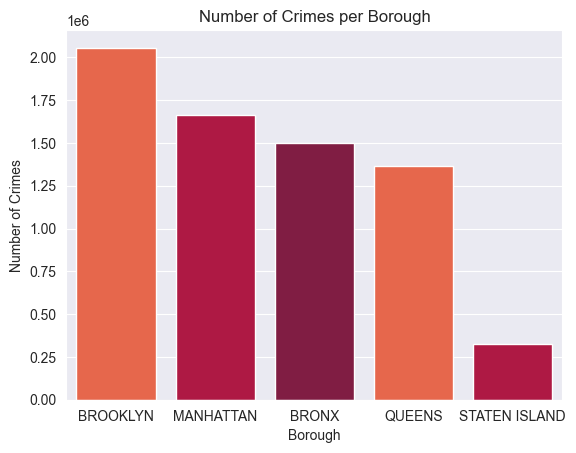

In [77]:
# plotting total number of crimes per borough
sns.set_style('darkgrid')
custom_palette = sns.color_palette(['#FF5733', '#C70039', '#900C3F'])
g=sns.barplot(x='Borough',y='count',data=borough_pddf,palette=custom_palette);
plt.ylabel('Number of Crimes');
plt.title("Number of Crimes per Borough");
display(g)